 <div>
 <h1><center>Applications de l'Informatique Quantique</h1>
<h2><center>Séance 1, Notebook 2 : Premier algorithme simple : la recherche de Grover</h2>
</div>
    
    

### Objectifs du notebook
    
Ce notebook vise à implémenter concrètement un premier algorithme simple, en l'occurrence une recherche de Grover. Il vise à **appréhender la manière de coder et d'exécuter un algorithme quantique, et de comprendre l'impact du bruit sur ces algorithmes**. 

### Rappels sur l'algorithme de Grover

L'algorithme de Grover permet la recherche d'un ou plusieurs éléments répondant à un critère en une complexité $O(\sqrt{N})$ (contre $O(N)$ pour l'approche classique).

Elle se compose des trois étapes suivantes :$⟨\psi|A|\psi⟩$
- Préparation d'un état de superposition uniforme, noté $|s⟩$
- Application de l'oracle $U=I-2|\omega⟩⟨\omega|$, où $|\omega⟩$ est l'état marqué correspondant à l'élément à rechercher. Cet oracle renverse la phase de l'état marqué et préserve tous les autres.
- Application de l'amplificateur d'amplitude $U=2|s⟩⟨s|-I$. Cet état inverse la phase de tous les états sauf celui de superposition uniforme. Dans la pratique, il amplifie le déphasage réalisé sur l'état $|\omega⟩$ et le rend plus probable.

Les deux dernières étapes sont répétées $r=\frac{\pi}{4.arcsin(\frac{1}{\sqrt{2^n}})}$ fois pour maximiser la probabilité de mesurer l'état $|\omega⟩$ en sortie

### Imports
    
Le notebook, comme la plupart des applications qui seront décrites dans ce module, s'appuie sur deux librairies principales :
- *qiskit* : pour la définition des circuits quantiques et leur préparation pour l'exécution
- *qiskit_aer* : pour la simulation du comportement des ordinateurs quantiques. Le module nous permettra d'exécuter nos circuits en pratique

In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

from qiskit.circuit.library import grover_operator

from qiskit_aer import AerSimulator

import math

### 1. Exemple pratique

Pour cet exemple pratique, on cherche à marquer l'état $|10⟩$

#### 1.1. Préparation de l'oracle

In [1]:
oracle=QuantumCircuit(2)

oracle.x(0)
oracle.cz(0,1)
oracle.x(0)


oracle.draw()

NameError: name 'QuantumCircuit' is not defined

#### 1.2. Définition de l'opérateur de Grover

L'opérateur de Grover peut soit être défini manuellement :

In [3]:
amplif_amplit = QuantumCircuit(2)
amplif_amplit.h([0,1])
amplif_amplit.x([0,1])
amplif_amplit.cz(0,1)
amplif_amplit.x([0,1])
amplif_amplit.h([0,1])

amplif_amplit.draw()

┌───┐┌───┐   ┌───┐┌───┐
q_0: ┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤├───┤ │ ├───┤├───┤
q_1: ┤ H ├┤ X ├─■─┤ X ├┤ H ├
     └───┘└───┘   └───┘└───┘

Mais qiskit permet également de définir l'opérateur de Grover (=oracle + amplification d'amplitude) directement :

In [4]:
grover_op = grover_operator(oracle)
grover_op.decompose().draw()

global phase: π
     ┌──────────┐     ┌──────────┐┌────────────┐┌──────────┐                   »
q_0: ┤ U(π,0,π) ├──■──┤ U(π,0,π) ├┤ U(π/2,0,π) ├┤ U(π,0,π) ├────────────────■──»
     └──┬───┬───┘┌─┴─┐└──┬───┬───┘├────────────┤├──────────┤┌────────────┐┌─┴─┐»
q_1: ───┤ H ├────┤ X ├───┤ H ├────┤ U(π/2,0,π) ├┤ U(π,0,π) ├┤ U(π/2,0,π) ├┤ X ├»
        └───┘    └───┘   └───┘    └────────────┘└──────────┘└────────────┘└───┘»
«      ┌──────────┐ ┌────────────┐              
«q_0: ─┤ U(π,0,π) ├─┤ U(π/2,0,π) ├──────────────
«     ┌┴──────────┴┐└┬──────────┬┘┌────────────┐
«q_1: ┤ U(π/2,0,π) ├─┤ U(π,0,π) ├─┤ U(π/2,0,π) ├
«     └────────────┘ └──────────┘ └────────────┘

On peut alors calculer le nombre de fois qu'il faudrait appliquer l'opérateur pour disposer du résultat optimal

In [5]:
optimal_num_iterations = math.pi /(4 * math.asin(math.sqrt(1 / 2**grover_op.num_qubits)))-1/2
optimal_num_iterations

0.9999999999999998

#### 1.3. Circuit complet et exécution

Il reste à rajouter la première étape qui consiste à préparer un état de superposition uniforme. 

In [6]:
qc = QuantumCircuit(grover_op.num_qubits)

qc.h(range(grover_op.num_qubits))
qc.compose(grover_op, inplace=True)
qc.measure_all()

qc.draw()

global phase: π
        ┌───┐┌───┐   ┌───┐┌───┐┌───┐     ┌───┐┌───┐      ░ ┌─┐   
   q_0: ┤ H ├┤ X ├─■─┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├──────░─┤M├───
        ├───┤└───┘ │ ├───┤├───┤├───┤┌─┴─┐├───┤├───┤┌───┐ ░ └╥┘┌─┐
   q_1: ┤ H ├──────■─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──╫─┤M├
        └───┘        └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║ └╥┘
meas: 2/════════════════════════════════════════════════════╩══╩═
                                                            0  1

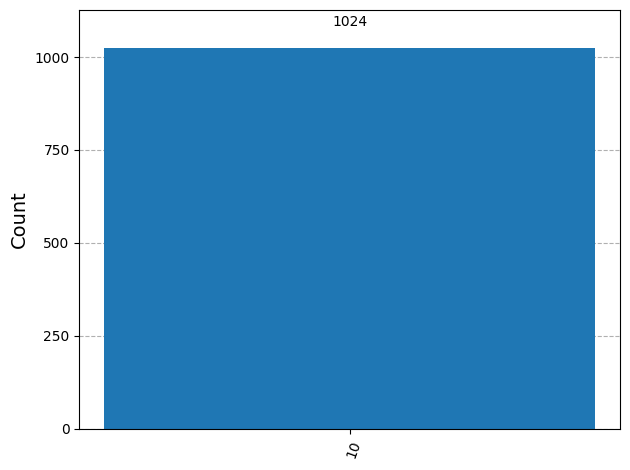

In [7]:
#génération d'un pass manager adapté à la machine (ici AerSimulator) et avec un niveau d'optimisation de 1
pass_manager = generate_preset_pass_manager(1, AerSimulator())

#optimisation du circuit au moyen du preset_pass_manager
isa_qc=pass_manager.run(qc)

#execution du job au moyen d'un sampler
sampler=Sampler()
job=sampler.run([isa_qc],shots=1024)
result=job.result()

#représentation sous forme d'histogramme
plot_histogram(result[0].data.meas.get_counts())

### 2. Exercices

<div class="alert alert-block alert-info">
<ul>
    <li>Exécuter l'algorithme précédent sur un modèle incluant du bruit (par exemple le modèle de l'ordinateur ibm_brisbane)
    <li>Conclure sur l'utilisabilité de l'algorithme en pratique, en régime NISQ
</ul>
</div>

<div class="alert alert-block alert-info">
A l'aide de l'algorithme de Grover, résoudre le problème de satisfaisabilité suivant :

Un éclairage est constitué de 3 lampes, notées A, B et C.

On cherche à savoir comment allumer les lampes A, B et C pour satisfaire **toutes** les conditions suivantes :
- L'une des trois lampes au moins doit être allumée
- Soit A est allumée, soit B est allumée, soit C est éteinte
- Soit A est éteinte, soit B est allumée, soit C est allumée
- Soit A est éteinte, soit B est allumée, soit C est éteinte
- Soit A est éteinte, soit B est éteinte, soit C est allumée

**Note**: ce problème pourrait très bien être résolu poar la logique simple. Ce n'est pas le but de l'exercice ici.
</div>